# Super Kriging

<!-- SUMMARY: Estimation in the framework of Super Kriging -->

<!-- CATEGORY: Methodology -->

This file is meant to demonstrate the use of gstlearn for Super Kriging. It is run on several 2-D cases.

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import gstlearn as gl
import gstlearn.plot as gp
import gstlearn.document as gdoc
import matplotlib.pyplot as plt

gdoc.setNoScroll()

<IPython.core.display.Javascript object>

Setting some global variables

In [2]:
# Set the Global Options
verbose = True
flagGraphic = True

# Define the Space Dimension
ndim = 2
gl.defineDefaultSpace(gl.ESpaceType.RN, ndim)

# Set the Seed for the Random Number generator
gl.law_set_random_seed(5584)

# Next option performs a verbose kriging of one target node (lots of outputs)
flagDebug = True

We define the grid on which all calculations will be performed. The grid is constituted of square meshes and has a rectangular extension of 200 by 150.

In [3]:
grid = gl.DbGrid.create(nx=[200,150],dx=[1.,1.])
grid


Data Base Grid Characteristics

Data Base Summary
-----------------
File is organized as a regular grid
Space dimension              = 2
Number of Columns            = 3
Total number of samples      = 30000

Grid characteristics:
---------------------
Origin :      0.000     0.000
Mesh   :      1.000     1.000
Number :        200       150

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x1 - Locator = x1
Column = 2 - Name = x2 - Locator = x2

# Poisson Data Set

In this paragraph, we generate a Poisson Data Set (data uniformy distributed along each space dimension) which covers the Grid expansion area. The Data Set contains 100 samples.

In [4]:
coormin = grid.getCoorMinimum()
coormax = grid.getCoorMaximum()
nech = 100
data = gl.Db.createFromBox(nech, coormin, coormax)

A variable is generated on this data set, as the result of a non-conditional simulation with a build-in model.

In [5]:
model = gl.Model()
model.addCovFromParam(gl.ECov.SPHERICAL, range=40, sill=0.7)
model.addCovFromParam(gl.ECov.NUGGET, sill = 0.3)
err = gl.simtub(None, dbout=data, model=model)
data


Data Base Characteristics

Data Base Summary
-----------------
File is organized as a set of isolated points
Space dimension              = 2
Number of Columns            = 4
Total number of samples      = 100

Variables
---------
Column = 0 - Name = rank - Locator = NA
Column = 1 - Name = x-1 - Locator = x1
Column = 2 - Name = x-2 - Locator = x2
Column = 3 - Name = Simu - Locator = z1

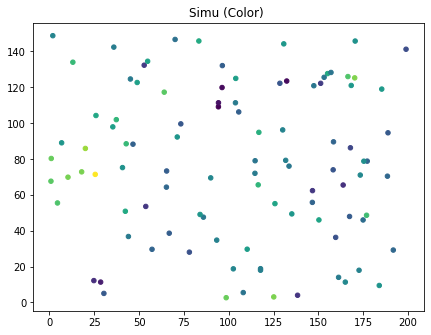

In [6]:
gp.setDefaultGeographic(dims=[7,7], aspect=1)
ax = data.plot(nameColor="Simu")

## Defining standard neighborhood

We first define a standard Moving Neighborhood.

In [7]:
nmini = 1
nmaxi = 10
radius = 30.
nsect = 8
nsmax = 3
neigh = gl.NeighMoving.create(flag_xvalid=False, nmaxi=nmaxi, radius=radius, nmini=nmini, 
                              nsect=nsect, nsmax=nsmax)
neigh


Moving Neighborhood
Minimum number of samples           = 1
Maximum number of samples           = 10
Number of angular sectors           = 8
Maximum number of points per sector = 3
Maximum horizontal distance         = 30

Checking the neighborhood around a central grid node

In [8]:
node = 15300
target = grid.getSampleCoordinates(node)
neigh.attach(data, grid)
ranks = gl.VectorInt()
neigh.select(node, ranks)

dataSel = data.clone()
dum = dataSel.addSelectionByRanks(ranks)

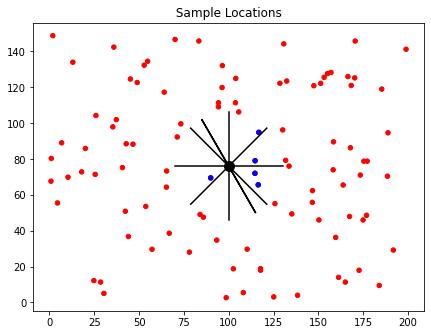

In [9]:
ax = data.plot()
ax = dataSel.plot(color='blue')
ax = gp.sample(target, color='black')
ax = gp.curve(grid.getCellEdges(node))
ax = gp.curve(neigh.getEllipsoid(target))
ax = gp.multisegments(target,neigh.getSectors(target))

### Point Kriging

Performing a Point Kriging with the current Neighborhood feature

In [10]:
err = gl.kriging(data, grid, model, neigh, 
                 namconv=gl.NamingConvention("Point_Kriging"))

In [11]:
if flagDebug:
    err = gl.krigtest(data, grid, model, neigh, node)


Target location
---------------
Sample #15301 (from 30000)
Coordinate #1 = 100.000000
Coordinate #2 = 76.000000

Data selected in neighborhood
-----------------------------
       Rank     Sample         x1         x2     Sector
          1         20    114.631     72.031          4
          2         52    116.444     65.590          4
          3         56    114.720     79.035          5
          4         65    116.816     94.871          6
          5         69     89.960     69.482          1

LHS of Kriging matrix
Dimension of the Covariance Matrix  = 5

       Rank          1          2          3          4          5
          1      1.000      0.526      0.518      0.164      0.132
          2      0.526      1.000      0.358      0.069      0.102
          3      0.518      0.358      1.000      0.303      0.106
          4      0.164      0.069      0.303      1.000      0.006
          5      0.132      0.102      0.106      0.006      1.000

RHS of Kriging matrix
N

The Point Kriging results are displayed (overlaying the control data points)

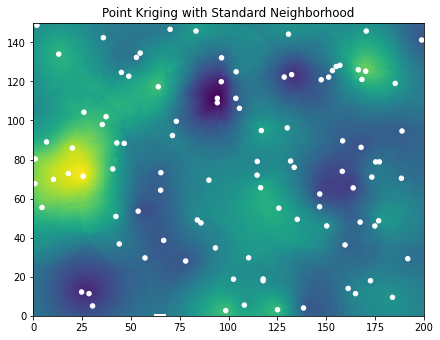

In [12]:
ax = grid.plot("Point_Kriging*estim")
ax = data.plot(color="white")
ax.decoration(title="Point Kriging with Standard Neighborhood")

We also display the standard deviation map of the Estimation error

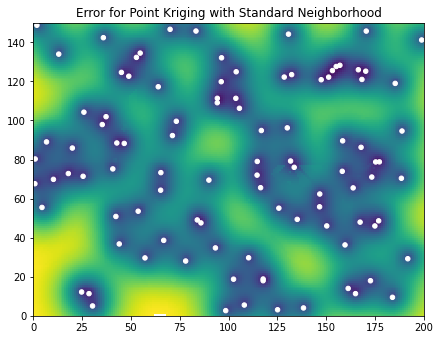

In [13]:
ax = grid.plot("Point_Kriging*stdev")
ax = data.plot(color="white")
ax.decoration(title="Error for Point Kriging with Standard Neighborhood")

### Block Kriging

Performing a Block Kriging with the current Neighborhood feature. Note that the discretization parameters have been set to small numbers in order to let the calculations be performed in a reasonable time frame (for a demonstration file).

In [14]:
ndiscs = [5,5]
err = gl.kriging(data, grid, model, neigh, calcul=gl.EKrigOpt.BLOCK, ndiscs=ndiscs,
                namconv=gl.NamingConvention("Block_Kriging"))

In [15]:
if flagDebug:
    err = gl.krigtest(data, grid, model, neigh, node, calcul=gl.EKrigOpt.BLOCK, ndiscs=ndiscs)


Target location
---------------
Sample #15301 (from 30000)
Coordinate #1 = 100.000000
Coordinate #2 = 76.000000

Data selected in neighborhood
-----------------------------
       Rank     Sample         x1         x2     Sector
          1         20    114.631     72.031          4
          2         52    116.444     65.590          4
          3         56    114.720     79.035          5
          4         65    116.816     94.871          6
          5         69     89.960     69.482          1

LHS of Kriging matrix
Dimension of the Covariance Matrix  = 5

       Rank          1          2          3          4          5
          1      1.000      0.526      0.518      0.164      0.132
          2      0.526      1.000      0.358      0.069      0.102
          3      0.518      0.358      1.000      0.303      0.106
          4      0.164      0.069      0.303      1.000      0.006
          5      0.132      0.102      0.106      0.006      1.000

RHS of Kriging matrix
N

The Block Kriging results are displayed (overlaying the control data points)

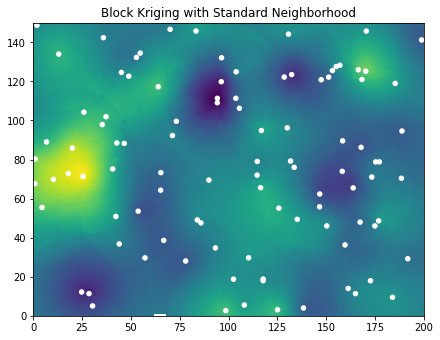

In [16]:
ax = grid.plot("Block_Kriging*estim")
ax = data.plot(color="white")
ax.decoration(title="Block Kriging with Standard Neighborhood")

We also display the standard deviation map of the Estimation error

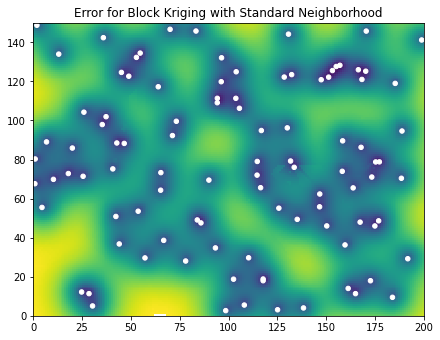

In [17]:
ax = grid.plot("Block_Kriging*stdev")
ax = data.plot(color="white")
ax.decoration(title="Error for Block Kriging with Standard Neighborhood")

Comparing the Estimation maps

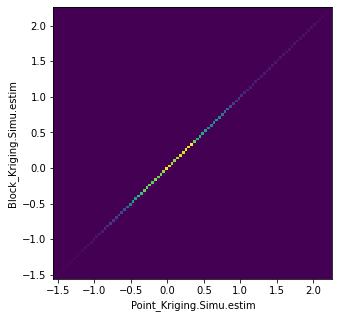

In [18]:
ax = gp.correlation(grid,namex="Point_Kriging*estim",namey="Block_Kriging*estim", bins=100)

Comparing the Error Estimation maps

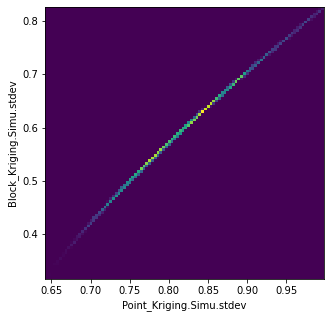

In [19]:
ax = gp.correlation(grid,namex="Point_Kriging*stdev",namey="Block_Kriging*stdev", bins=100)

The difference is not very impressive due to the small size of block extensions

## Defining variable Block Extensions

In this section, we will generate variables in the Grid File, which contain the cell extension. The square Block size is fixed to 50.

In [20]:
size = 50.
iuid = grid.addColumnsByConstant(1, size, "X-ext", gl.ELoc.BLEX, 0)
iuid = grid.addColumnsByConstant(1, size, "Y-ext", gl.ELoc.BLEX, 1)

The now check the neighborhood feature which consists in forcing any sample located within the cell extension centered on the target grid node.

In [21]:
nmini = 1
neighC = gl.NeighCell.create(flag_xvalid=False, nmini=nmini)
neighC.display()


Cell Neighborhood
Reject samples which do not belong to target Block


We check the new neighborhood on the same target grid node as before

In [22]:
neighC.attach(data, grid)
ranks = gl.VectorInt()
neighC.select(node, ranks)
dataSel = data.clone()
dum = dataSel.addSelectionByRanks(ranks)

The next figure displays the samples selected in the neighborhood of the target node (same as before). As expected all samples lying within the super_block centered on the target node are considered (i.e. 34) rather than the samples which would have been considered in the standard neighborhood case (i.e. 15).

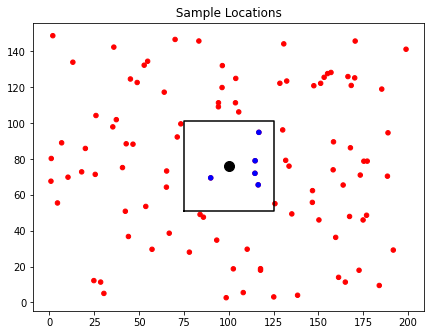

In [23]:
ax = data.plot()
ax = dataSel.plot(color='blue')
ax = gp.sample(target, color='black')
ax = gp.curve(grid.getCellEdges(node), color='black')

We now perform the Super Kriging which is nothing but a standard Kriging with the new neighborhood feature (demonstrated above).

In [24]:
err = gl.kriging(data, grid, model, neighC, calcul=gl.EKrigOpt.BLOCK, ndiscs=ndiscs,
                 namconv=gl.NamingConvention("Super_Kriging"))

In [ ]:
if flagDebug:
    err = gl.krigtest(data, grid, model, neighC, node, calcul=gl.EKrigOpt.BLOCK, ndiscs=ndiscs)

The results of the Super Kriging are visualized in the next figure, together with the ones of the standard neighborhood.

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(16,8))

axs[0].gstgrid(grid,"Super_Kriging*estim") 
axs[0].gstpoint(data,color="white")
axs[0].decoration(title="Super Block Kriging")

axs[1].gstgrid(grid,"Block_Kriging*estim")
axs[1].gstpoint(data,color="white")
axs[1].decoration(title="Block Kriging with Standard Neighborhood")

We also display the standard deviation map of the Super Kriging Estimation error

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,8))

axs[0].gstgrid(grid,"Super_Kriging*stdev")
axs[0].gstpoint(data,color="white")
axs[0].decoration(title="Error for Super Block Kriging")

axs[1].gstgrid(grid,"Block_Kriging*stdev")
axs[1].gstpoint(data,color="white")
axs[1].decoration(title="Error for Block Kriging with Standard Neighborhood")

Comparing with Block Kriging with standard block extension (equal to the grid mesh)

In [ ]:
ax = gp.correlation(grid,namex="Block_Kriging*estim",namey="Super_Kriging*estim", bins=100)

Comparing the error maps

In [ ]:
ax = gp.correlation(grid,namex="Block_Kriging*stdev",namey="Super_Kriging*stdev", bins=100)